In [25]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, cross_validate,cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import joblib
import shap
from sklearn.inspection import permutation_importance

In [ ]:
import os
os.chdir(r'C:\Users\ADMIN\Desktop\EMLforSAI')  #Replace with the file path of EMLforSAI in your system.

In [ ]:
# 1. 读取数据
df=pd.read_csv(r'./Dataset/ML_data.csv')

In [ ]:
# 2. 数据预处理
df = df.dropna(subset=['y'])
feature_columns = ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'B5', 
                   'C1', 'C2', 'C3', 'C4']

def categorize_y(value):
    if pd.isna(value):
        return np.nan
    elif value <= 3:
        return 2
    elif value == 4:
        return 1
    elif value == 5:
        return 0
    else:
        return np.nan

df['y_category'] = df['y'].apply(categorize_y)
df = df.dropna(subset=['y_category'])

X = df[feature_columns]
y = df['y_category']

In [19]:
# 3. 设置五折交叉验证
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("=== Optuna贝叶斯优化调参 (SVC) ===")
print(f"样本数: {len(X)}, 特征数: {len(feature_columns)}")
print(f"类别分布: {dict(y.value_counts().sort_index())}")
print(f"类别比例: {y.value_counts(normalize=True).sort_index().values}")

# 4. 定义Optuna目标函数 (针对SVC)
def objective(trial):
    """
    Optuna目标函数，返回交叉验证的准确率
    """
    # 定义SVC参数搜索空间
    C = trial.suggest_float('C', 0.1, 10, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    
    # 条件参数：当核函数为'rbf'、'poly'或'sigmoid'时，gamma也可以为浮点数
    if trial.suggest_categorical('use_gamma_value', [True, False]):
        gamma = trial.suggest_float('gamma_value', 0.001, 1, log=True)
    
    # 条件参数：当核函数为'poly'或'sigmoid'时，设置degree
    degree = 3  # 默认值
    if kernel in ['poly', 'sigmoid']:
        degree = trial.suggest_int('degree', 2, 5)
    
    # 条件参数：当核函数为'poly'或'sigmoid'时，设置coef0
    coef0 = 0.0  # 默认值
    if kernel in ['poly', 'sigmoid']:
        coef0 = trial.suggest_float('coef0', 0.0, 1.0)
    
    # 定义class_weight选项
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    
    # 定义shrinking选项
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    
    # 定义probability选项（为后续概率预测）
    probability = trial.suggest_categorical('probability', [True, False])
    
    # 定义tol（容忍度）
    tol = trial.suggest_float('tol', 1e-5, 1e-2, log=True)
    
    # 创建SVC模型
    model = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        degree=degree,
        coef0=coef0,
        class_weight=class_weight,
        shrinking=shrinking,
        probability=probability,
        tol=tol,
        random_state=42,
        cache_size=500  # 增大缓存以加速计算
    )
    
    # 创建Pipeline：标准化 + SVC
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', model)
    ])
    
    # 使用交叉验证计算分数
    scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy', n_jobs=1)
    
    # 返回平均准确率
    return np.mean(scores)

# 5. 创建Optuna研究并运行优化
print("\n开始Optuna贝叶斯优化...")
study = optuna.create_study(
    direction='maximize',  # 最大化准确率
    sampler=TPESampler(seed=42),  # 使用TPE采样器
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3, interval_steps=1)
)

# 运行优化（SVC训练较慢，减少试验次数）
n_trials = 100  # 试验次数（SVC训练慢，减少次数）
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)


[I 2025-12-20 14:45:50,858] A new study created in memory with name: no-name-5dc58a12-7fd0-40f8-b611-9cba69a6ba5a


=== Optuna贝叶斯优化调参 (SVC) ===
样本数: 687, 特征数: 13
类别分布: {0: 148, 1: 289, 2: 250}
类别比例: [0.2154294  0.42066958 0.36390102]

开始Optuna贝叶斯优化...


Best trial: 0. Best value: 0.790522:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-20 14:45:50,907] Trial 0 finished with value: 0.7905215275573891 and parameters: {'C': 0.5611516415334505, 'kernel': 'linear', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.13311216080736885, 'class_weight': 'balanced', 'shrinking': True, 'probability': False, 'tol': 8.17949947521167e-05}. Best is trial 0 with value: 0.7905215275573891.


Best trial: 1. Best value: 0.807892:   2%|▏         | 2/100 [00:00<00:09, 10.69it/s]

[I 2025-12-20 14:45:51,045] Trial 1 finished with value: 0.8078916746006559 and parameters: {'C': 1.1207606211860568, 'kernel': 'rbf', 'gamma': 'auto', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.5673095467235405e-05}. Best is trial 1 with value: 0.8078916746006559.


Best trial: 1. Best value: 0.807892:   4%|▍         | 4/100 [00:00<00:13,  6.91it/s]

[I 2025-12-20 14:45:51,267] Trial 2 finished with value: 0.7890722521950704 and parameters: {'C': 7.902619549708233, 'kernel': 'linear', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': False, 'probability': False, 'tol': 0.00043664735929796326}. Best is trial 1 with value: 0.8078916746006559.
[I 2025-12-20 14:45:51,406] Trial 3 finished with value: 0.7963186290066646 and parameters: {'C': 0.23426581058204046, 'kernel': 'linear', 'gamma': 'auto', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 6.963114377829287e-05}. Best is trial 1 with value: 0.8078916746006559.


Best trial: 6. Best value: 0.815191:   6%|▌         | 6/100 [00:00<00:12,  7.32it/s]

[I 2025-12-20 14:45:51,521] Trial 4 finished with value: 0.5851898868084207 and parameters: {'C': 1.2172847081122433, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': False, 'degree': 4, 'coef0': 0.7290071680409873, 'class_weight': None, 'shrinking': True, 'probability': True, 'tol': 9.833181933644887e-05}. Best is trial 1 with value: 0.8078916746006559.
[I 2025-12-20 14:45:51,660] Trial 5 finished with value: 0.8035544271659791 and parameters: {'C': 0.13400367243354802, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': None, 'shrinking': True, 'probability': True, 'tol': 1.1919481947918725e-05}. Best is trial 1 with value: 0.8078916746006559.
[I 2025-12-20 14:45:51,695] Trial 6 finished with value: 0.8151909446736486 and parameters: {'C': 0.16435497475111327, 'kernel': 'poly', 'gamma': 'scale', 'use_gamma_value': False, 'degree': 2, 'coef0': 0.07697990982879299, 'class_weight': None, 'shrinking': True, 'probability': False, 'tol': 0.0025764174425233

Best trial: 6. Best value: 0.815191:   9%|▉         | 9/100 [00:01<00:09,  9.69it/s]

[I 2025-12-20 14:45:51,748] Trial 7 finished with value: 0.49196022426742836 and parameters: {'C': 0.23612399244412613, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': False, 'degree': 5, 'coef0': 0.8607305832563434, 'class_weight': 'balanced', 'shrinking': True, 'probability': False, 'tol': 0.0067410742656406975}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:51,889] Trial 8 finished with value: 0.8064635565428965 and parameters: {'C': 0.4430021806767983, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.007153547794693156, 'degree': 2, 'coef0': 0.6095643339798968, 'class_weight': None, 'shrinking': False, 'probability': True, 'tol': 0.0002940074130903306}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  10%|█         | 10/100 [00:01<00:10,  8.95it/s]

[I 2025-12-20 14:45:52,033] Trial 9 finished with value: 0.7962234211361472 and parameters: {'C': 9.360540102485377, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': None, 'shrinking': True, 'probability': True, 'tol': 0.0005924870051994319}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  11%|█         | 11/100 [00:01<00:13,  6.38it/s]

[I 2025-12-20 14:45:52,340] Trial 10 finished with value: 0.7641806833809373 and parameters: {'C': 2.50953825477877, 'kernel': 'poly', 'gamma': 'auto', 'use_gamma_value': True, 'gamma_value': 0.8176402250908494, 'degree': 2, 'coef0': 0.015193683027474626, 'class_weight': None, 'shrinking': False, 'probability': False, 'tol': 0.006891558894035219}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:52,391] Trial 11 finished with value: 0.8064423992383369 and parameters: {'C': 1.7784523829842054, 'kernel': 'poly', 'gamma': 'auto', 'use_gamma_value': False, 'degree': 3, 'coef0': 0.07413580388854404, 'class_weight': 'balanced', 'shrinking': True, 'probability': False, 'tol': 0.0018675378420212865}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  13%|█▎        | 13/100 [00:01<00:12,  7.21it/s]

[I 2025-12-20 14:45:52,563] Trial 12 finished with value: 0.7991642864699038 and parameters: {'C': 3.8165556248635206, 'kernel': 'poly', 'gamma': 'auto', 'use_gamma_value': False, 'degree': 3, 'coef0': 0.3061482796989612, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.2199085680171404e-05}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:52,607] Trial 13 finished with value: 0.8064529778906167 and parameters: {'C': 0.6821018330793579, 'kernel': 'rbf', 'gamma': 'auto', 'use_gamma_value': False, 'class_weight': None, 'shrinking': True, 'probability': False, 'tol': 0.002319170016880128}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  16%|█▌        | 16/100 [00:02<00:10,  7.77it/s]

[I 2025-12-20 14:45:52,786] Trial 14 finished with value: 0.5154342536760816 and parameters: {'C': 0.1014767250039257, 'kernel': 'poly', 'gamma': 'auto', 'use_gamma_value': True, 'gamma_value': 0.0027797316240179173, 'degree': 2, 'coef0': 0.3495542064902408, 'class_weight': 'balanced', 'shrinking': False, 'probability': True, 'tol': 3.062099933595148e-05}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:52,830] Trial 15 finished with value: 0.8064529778906167 and parameters: {'C': 0.2876822908560948, 'kernel': 'rbf', 'gamma': 'auto', 'use_gamma_value': False, 'class_weight': None, 'shrinking': True, 'probability': False, 'tol': 0.0015717429968984233}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:52,876] Trial 16 finished with value: 0.8020205225854227 and parameters: {'C': 0.9189941362445053, 'kernel': 'poly', 'gamma': 'auto', 'use_gamma_value': False, 'degree': 4, 'coef0': 0.2759669838668322, 'class_weight': 'balanced', 'shrinking': True, 'pr

Best trial: 6. Best value: 0.815191:  19%|█▉        | 19/100 [00:02<00:09,  8.90it/s]

[I 2025-12-20 14:45:53,012] Trial 17 finished with value: 0.7976621178461863 and parameters: {'C': 3.9062037013667563, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': None, 'shrinking': True, 'probability': True, 'tol': 0.000947199306822671}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:53,157] Trial 18 finished with value: 0.7991431291653444 and parameters: {'C': 1.1812592550161596, 'kernel': 'poly', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.046167167606196095, 'degree': 3, 'coef0': 0.9717012751604345, 'class_weight': 'balanced', 'shrinking': False, 'probability': True, 'tol': 2.850603924097963e-05}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  20%|██        | 20/100 [00:02<00:08,  8.90it/s]

[I 2025-12-20 14:45:53,201] Trial 19 finished with value: 0.8064529778906167 and parameters: {'C': 0.31912159510805965, 'kernel': 'rbf', 'gamma': 'auto', 'use_gamma_value': False, 'class_weight': None, 'shrinking': True, 'probability': False, 'tol': 0.004212246309731171}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:53,246] Trial 20 finished with value: 0.803490955252301 and parameters: {'C': 0.17209965545916425, 'kernel': 'poly', 'gamma': 'scale', 'use_gamma_value': False, 'degree': 5, 'coef0': 0.5032108305941809, 'class_weight': None, 'shrinking': True, 'probability': False, 'tol': 0.00020323519409216892}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  23%|██▎       | 23/100 [00:02<00:08,  9.23it/s]

[I 2025-12-20 14:45:53,413] Trial 21 finished with value: 0.4526711097006242 and parameters: {'C': 0.40792375232316064, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.0016612891281108128, 'degree': 2, 'coef0': 0.6156929222471749, 'class_weight': None, 'shrinking': False, 'probability': True, 'tol': 0.0002504014085664268}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:53,559] Trial 22 finished with value: 0.8093832645720935 and parameters: {'C': 0.5263674780287423, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.008294946068137988, 'degree': 2, 'coef0': 0.49267344280744085, 'class_weight': None, 'shrinking': False, 'probability': True, 'tol': 0.0009257911822987029}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  25%|██▌       | 25/100 [00:02<00:08,  8.93it/s]

[I 2025-12-20 14:45:53,689] Trial 23 finished with value: 0.8065058711520153 and parameters: {'C': 0.6729339151089926, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.013828005720532447, 'degree': 2, 'coef0': 0.16448804475298406, 'class_weight': None, 'shrinking': False, 'probability': True, 'tol': 0.0008657407325011651}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:53,798] Trial 24 finished with value: 0.6101026129271131 and parameters: {'C': 1.9575113606331156, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.07402783538286764, 'degree': 3, 'coef0': 0.4358407227839422, 'class_weight': None, 'shrinking': False, 'probability': True, 'tol': 0.0027330305542478195}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  27%|██▋       | 27/100 [00:03<00:09,  7.86it/s]

[I 2025-12-20 14:45:53,957] Trial 25 finished with value: 0.660880143869671 and parameters: {'C': 0.1526752525012377, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.009260653548571638, 'degree': 2, 'coef0': 0.1780180889349841, 'class_weight': None, 'shrinking': False, 'probability': True, 'tol': 0.0009770639584336695}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:54,097] Trial 26 finished with value: 0.7860679149476357 and parameters: {'C': 0.7920208626334153, 'kernel': 'rbf', 'gamma': 'auto', 'use_gamma_value': True, 'gamma_value': 0.23139595311445202, 'class_weight': 'balanced', 'shrinking': False, 'probability': True, 'tol': 0.004739709550222225}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  29%|██▉       | 29/100 [00:03<00:09,  7.66it/s]

[I 2025-12-20 14:45:54,236] Trial 27 finished with value: 0.7890405162382312 and parameters: {'C': 0.4492989631619898, 'kernel': 'linear', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': None, 'shrinking': True, 'probability': True, 'tol': 0.0013804215636663546}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:54,282] Trial 28 finished with value: 0.8021157304559399 and parameters: {'C': 1.4621683084538823, 'kernel': 'poly', 'gamma': 'auto', 'use_gamma_value': True, 'gamma_value': 0.023333521082887446, 'degree': 4, 'coef0': 0.46378435114083266, 'class_weight': 'balanced', 'shrinking': False, 'probability': False, 'tol': 0.0004973592364637398}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:54,326] Trial 29 finished with value: 0.8035861631228182 and parameters: {'C': 0.10661919124949182, 'kernel': 'linear', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.0040673709000974955, 'class_weight': 'balanced', 'shrinking': True, 

Best trial: 6. Best value: 0.815191:  32%|███▏      | 32/100 [00:03<00:07,  9.39it/s]

[I 2025-12-20 14:45:54,459] Trial 30 finished with value: 0.5313868613138686 and parameters: {'C': 0.5455903912706106, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': False, 'degree': 3, 'coef0': 0.7368347354837554, 'class_weight': None, 'shrinking': True, 'probability': True, 'tol': 0.009928294554649405}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:54,589] Trial 31 finished with value: 0.8050565957896965 and parameters: {'C': 0.6720777208709332, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.018404456643537258, 'degree': 2, 'coef0': 0.12755692142862296, 'class_weight': None, 'shrinking': False, 'probability': True, 'tol': 0.0007893413374659481}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  34%|███▍      | 34/100 [00:04<00:08,  8.09it/s]

[I 2025-12-20 14:45:54,725] Trial 32 finished with value: 0.8094150005289327 and parameters: {'C': 0.5913014664550641, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.01227496372939633, 'degree': 2, 'coef0': 0.20121174982429765, 'class_weight': None, 'shrinking': False, 'probability': True, 'tol': 0.0032394462417292815}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:54,882] Trial 33 finished with value: 0.6623188405797101 and parameters: {'C': 0.9834731558470221, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.0012034282190702475, 'degree': 2, 'coef0': 0.25840889049688387, 'class_weight': None, 'shrinking': False, 'probability': True, 'tol': 0.0033186710672273418}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  36%|███▌      | 36/100 [00:04<00:08,  7.92it/s]

[I 2025-12-20 14:45:55,018] Trial 34 finished with value: 0.7963186290066646 and parameters: {'C': 0.2951339352566952, 'kernel': 'linear', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.004960976226931665, 'class_weight': None, 'shrinking': False, 'probability': True, 'tol': 0.0013923353067823746}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:55,143] Trial 35 finished with value: 0.7454458901935893 and parameters: {'C': 3.3988861002652007, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.03559081201141481, 'degree': 3, 'coef0': 0.02663693278889414, 'class_weight': None, 'shrinking': False, 'probability': True, 'tol': 5.042748160766565e-05}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  39%|███▉      | 39/100 [00:04<00:06,  9.02it/s]

[I 2025-12-20 14:45:55,286] Trial 36 finished with value: 0.8064741351951762 and parameters: {'C': 0.20500488288683538, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': False, 'probability': True, 'tol': 0.0047872927427747665}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:55,329] Trial 37 finished with value: 0.6493176769279594 and parameters: {'C': 5.774148104724841, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': False, 'degree': 2, 'coef0': 0.386528041242769, 'class_weight': None, 'shrinking': True, 'probability': False, 'tol': 0.0003638030573731664}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:55,457] Trial 38 finished with value: 0.7905109489051095 and parameters: {'C': 0.36258111229215634, 'kernel': 'linear', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.011625315353447508, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 0.00262238

Best trial: 6. Best value: 0.815191:  43%|████▎     | 43/100 [00:04<00:04, 12.87it/s]

[I 2025-12-20 14:45:55,574] Trial 39 finished with value: 0.6523537501322332 and parameters: {'C': 0.567763251172057, 'kernel': 'sigmoid', 'gamma': 'auto', 'use_gamma_value': False, 'degree': 2, 'coef0': 0.20118745111124595, 'class_weight': None, 'shrinking': False, 'probability': True, 'tol': 0.0006269286396011893}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:55,618] Trial 40 finished with value: 0.8078705172960966 and parameters: {'C': 1.2453617650147002, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': None, 'shrinking': True, 'probability': False, 'tol': 0.006681669616668926}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:55,662] Trial 41 finished with value: 0.8078705172960966 and parameters: {'C': 1.29638189005874, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': None, 'shrinking': True, 'probability': False, 'tol': 0.009728693397360821}. Best is trial 6 with value: 0.81519094467

Best trial: 6. Best value: 0.815191:  46%|████▌     | 46/100 [00:05<00:03, 15.78it/s]

[I 2025-12-20 14:45:55,793] Trial 44 finished with value: 0.8078916746006559 and parameters: {'C': 0.880150585394149, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': None, 'shrinking': True, 'probability': False, 'tol': 0.0065313635943064505}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:55,837] Trial 45 finished with value: 0.8049931238760182 and parameters: {'C': 0.5265386525739385, 'kernel': 'poly', 'gamma': 'auto', 'use_gamma_value': False, 'degree': 3, 'coef0': 0.5583656484319746, 'class_weight': None, 'shrinking': True, 'probability': False, 'tol': 0.001954656604198275}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:55,885] Trial 46 finished with value: 0.8093515286152545 and parameters: {'C': 0.8540415627282794, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': False, 'tol': 1.784455550650275e-05}. Best is trial 6 with value: 0.815190

Best trial: 6. Best value: 0.815191:  48%|████▊     | 48/100 [00:05<00:03, 14.30it/s]

[I 2025-12-20 14:45:56,009] Trial 47 finished with value: 0.5765894425050249 and parameters: {'C': 1.0614711521956643, 'kernel': 'sigmoid', 'gamma': 'auto', 'use_gamma_value': False, 'degree': 2, 'coef0': 0.08971057045183761, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.741512458287748e-05}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:56,071] Trial 48 finished with value: 0.4116153602031101 and parameters: {'C': 0.21037739888121837, 'kernel': 'poly', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.002516080327593983, 'degree': 3, 'coef0': 0.2562568808093947, 'class_weight': 'balanced', 'shrinking': False, 'probability': False, 'tol': 1.1169833278646624e-05}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  50%|█████     | 50/100 [00:05<00:03, 12.62it/s]

[I 2025-12-20 14:45:56,213] Trial 49 finished with value: 0.809362107267534 and parameters: {'C': 0.8037587153771114, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.901924793467269e-05}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:56,354] Trial 50 finished with value: 0.809362107267534 and parameters: {'C': 0.7638260370310392, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 2.501119971742573e-05}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  52%|█████▏    | 52/100 [00:05<00:04, 10.29it/s]

[I 2025-12-20 14:45:56,495] Trial 51 finished with value: 0.8108219612821326 and parameters: {'C': 0.7493432637576154, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 2.1896692584514308e-05}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:56,633] Trial 52 finished with value: 0.8093726859198138 and parameters: {'C': 0.7301358146038274, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 2.462377703127179e-05}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  54%|█████▍    | 54/100 [00:06<00:05,  9.16it/s]

[I 2025-12-20 14:45:56,770] Trial 53 finished with value: 0.8093515286152544 and parameters: {'C': 0.4787753293824523, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 5.461172043731232e-05}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:56,907] Trial 54 finished with value: 0.8079022532529356 and parameters: {'C': 0.5929558251736811, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 4.1785808342278666e-05}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  57%|█████▋    | 57/100 [00:06<00:05,  8.55it/s]

[I 2025-12-20 14:45:57,046] Trial 55 finished with value: 0.8050037025282979 and parameters: {'C': 0.36889537237022735, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 2.3274187257985405e-05}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:57,159] Trial 56 finished with value: 0.8064423992383369 and parameters: {'C': 0.6712694338385469, 'kernel': 'poly', 'gamma': 'scale', 'use_gamma_value': False, 'degree': 2, 'coef0': 0.7044912635344005, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.4385019997200697e-05}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  59%|█████▉    | 59/100 [00:06<00:05,  7.80it/s]

[I 2025-12-20 14:45:57,310] Trial 57 finished with value: 0.5602771606897281 and parameters: {'C': 0.2371518758458896, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.06984620753925516, 'degree': 4, 'coef0': 0.3904334584684422, 'class_weight': 'balanced', 'shrinking': False, 'probability': True, 'tol': 3.872236888971396e-05}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:57,454] Trial 58 finished with value: 0.8035121125568601 and parameters: {'C': 1.4869972968422511, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 2.1382258926024982e-05}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  61%|██████    | 61/100 [00:07<00:07,  5.04it/s]

[I 2025-12-20 14:45:57,959] Trial 59 finished with value: 0.7845551676716386 and parameters: {'C': 1.1017296045584493, 'kernel': 'poly', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.511655744108431, 'degree': 2, 'coef0': 0.22786804177427447, 'class_weight': 'balanced', 'shrinking': False, 'probability': True, 'tol': 0.00015432868454311896}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:58,098] Trial 60 finished with value: 0.8079022532529356 and parameters: {'C': 0.4119955196032742, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 6.886549367252353e-05}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  63%|██████▎   | 63/100 [00:07<00:06,  5.83it/s]

[I 2025-12-20 14:45:58,239] Trial 61 finished with value: 0.809362107267534 and parameters: {'C': 0.7689460924257793, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 2.848960059211719e-05}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:58,380] Trial 62 finished with value: 0.8093726859198138 and parameters: {'C': 0.7192738663747228, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.3900864358637158e-05}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  65%|██████▌   | 65/100 [00:07<00:05,  6.40it/s]

[I 2025-12-20 14:45:58,522] Trial 63 finished with value: 0.8079022532529356 and parameters: {'C': 0.609413077207341, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.0692745006376295e-05}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:58,661] Trial 64 finished with value: 0.8093515286152544 and parameters: {'C': 0.4818353148120368, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.4293099680638618e-05}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  67%|██████▋   | 67/100 [00:08<00:04,  6.81it/s]

[I 2025-12-20 14:45:58,797] Trial 65 finished with value: 0.5663810430551148 and parameters: {'C': 0.9652780448471677, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': False, 'degree': 3, 'coef0': 0.11017339546538144, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.9817875698782612e-05}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:58,935] Trial 66 finished with value: 0.7919602242674284 and parameters: {'C': 0.2558706519793206, 'kernel': 'linear', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.006105606540556438, 'class_weight': 'balanced', 'shrinking': False, 'probability': True, 'tol': 0.0011468704868585406}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  69%|██████▉   | 69/100 [00:08<00:04,  7.46it/s]

[I 2025-12-20 14:45:59,065] Trial 67 finished with value: 0.8079128319052152 and parameters: {'C': 0.3446504686696276, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': None, 'shrinking': True, 'probability': True, 'tol': 3.655934422407559e-05}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:59,181] Trial 68 finished with value: 0.7977255897598645 and parameters: {'C': 0.7672137412133813, 'kernel': 'poly', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.025399075002092812, 'degree': 4, 'coef0': 0.8121424831042827, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.393529058643985e-05}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  71%|███████   | 71/100 [00:08<00:03,  7.35it/s]

[I 2025-12-20 14:45:59,298] Trial 69 finished with value: 0.6392362213054058 and parameters: {'C': 0.6486202694752932, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': False, 'degree': 5, 'coef0': 0.33114396652039024, 'class_weight': None, 'shrinking': False, 'probability': True, 'tol': 0.0019439147783221816}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:59,451] Trial 70 finished with value: 0.7787686448746429 and parameters: {'C': 0.5052984903725234, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.25771577324602135, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 2.92743025939702e-05}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  73%|███████▎  | 73/100 [00:08<00:03,  7.03it/s]

[I 2025-12-20 14:45:59,591] Trial 71 finished with value: 0.8108219612821326 and parameters: {'C': 0.7550459241231297, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 2.3402210220078572e-05}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:45:59,745] Trial 72 finished with value: 0.8123029726012906 and parameters: {'C': 0.12836886375992962, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.6656517107382353e-05}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  75%|███████▌  | 75/100 [00:09<00:03,  6.66it/s]

[I 2025-12-20 14:45:59,906] Trial 73 finished with value: 0.8123029726012906 and parameters: {'C': 0.12591132565445987, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.0047307350398323e-05}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:46:00,062] Trial 74 finished with value: 0.8123029726012906 and parameters: {'C': 0.12151388102755936, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 0.00013217840581461793}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  77%|███████▋  | 77/100 [00:09<00:03,  6.54it/s]

[I 2025-12-20 14:46:00,235] Trial 75 finished with value: 0.6826510102612928 and parameters: {'C': 0.1180926161549849, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': False, 'degree': 2, 'coef0': 0.013639393326150967, 'class_weight': 'balanced', 'shrinking': False, 'probability': True, 'tol': 0.00015602517107457506}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:46:00,379] Trial 76 finished with value: 0.8035544271659791 and parameters: {'C': 0.13946806712179405, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': None, 'shrinking': True, 'probability': True, 'tol': 0.0003484241950288906}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  79%|███████▉  | 79/100 [00:09<00:03,  6.65it/s]

[I 2025-12-20 14:46:00,491] Trial 77 finished with value: 0.7948693536443456 and parameters: {'C': 0.18265638128642303, 'kernel': 'linear', 'gamma': 'scale', 'use_gamma_value': False, 'class_weight': None, 'shrinking': True, 'probability': True, 'tol': 0.0006138306465465675}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:46:00,663] Trial 78 finished with value: 0.2881942240558553 and parameters: {'C': 0.12896156496040714, 'kernel': 'poly', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.0030945993533328937, 'degree': 3, 'coef0': 0.5458007800293635, 'class_weight': 'balanced', 'shrinking': False, 'probability': True, 'tol': 7.228567306314929e-05}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 6. Best value: 0.815191:  81%|████████  | 81/100 [00:10<00:03,  6.28it/s]

[I 2025-12-20 14:46:00,827] Trial 79 finished with value: 0.6726647625092563 and parameters: {'C': 0.16479881373609445, 'kernel': 'sigmoid', 'gamma': 'scale', 'use_gamma_value': False, 'degree': 2, 'coef0': 0.6562676956053478, 'class_weight': None, 'shrinking': True, 'probability': True, 'tol': 0.0024167919077975612}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:46:00,998] Trial 80 finished with value: 0.8137628266158892 and parameters: {'C': 0.10229683009171761, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.05310007653342646, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.0371496181509235e-05}. Best is trial 6 with value: 0.8151909446736486.


Best trial: 82. Best value: 0.815212:  83%|████████▎ | 83/100 [00:10<00:02,  6.14it/s]

[I 2025-12-20 14:46:01,166] Trial 81 finished with value: 0.8108431185866921 and parameters: {'C': 0.1038868271234641, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.07417199964801315, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.0860851016865338e-05}. Best is trial 6 with value: 0.8151909446736486.
[I 2025-12-20 14:46:01,332] Trial 82 finished with value: 0.8152121019782079 and parameters: {'C': 0.10180269574739777, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.09377902157243964, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.1991780257526452e-05}. Best is trial 82 with value: 0.8152121019782079.


Best trial: 82. Best value: 0.815212:  85%|████████▌ | 85/100 [00:10<00:02,  6.14it/s]

[I 2025-12-20 14:46:01,498] Trial 83 finished with value: 0.7933777636729081 and parameters: {'C': 0.10205505872654365, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.1396046106617066, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.1724418639613184e-05}. Best is trial 82 with value: 0.8152121019782079.
[I 2025-12-20 14:46:01,658] Trial 84 finished with value: 0.8050142811805776 and parameters: {'C': 0.12239356768710509, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.12333924004826947, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.0834300601677115e-05}. Best is trial 82 with value: 0.8152121019782079.


Best trial: 82. Best value: 0.815212:  87%|████████▋ | 87/100 [00:11<00:02,  6.26it/s]

[I 2025-12-20 14:46:01,814] Trial 85 finished with value: 0.8137628266158892 and parameters: {'C': 0.1513085004396786, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.05726449262798968, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.6012472115170676e-05}. Best is trial 82 with value: 0.8152121019782079.
[I 2025-12-20 14:46:01,972] Trial 86 finished with value: 0.8137628266158892 and parameters: {'C': 0.1437416766432949, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.05142882113349107, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.64087709174102e-05}. Best is trial 82 with value: 0.8152121019782079.


Best trial: 82. Best value: 0.815212:  89%|████████▉ | 89/100 [00:11<00:01,  6.29it/s]

[I 2025-12-20 14:46:02,129] Trial 87 finished with value: 0.8123135512535704 and parameters: {'C': 0.14669592734527992, 'kernel': 'rbf', 'gamma': 'scale', 'use_gamma_value': True, 'gamma_value': 0.056249686263534736, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.5946210870670524e-05}. Best is trial 82 with value: 0.8152121019782079.
[I 2025-12-20 14:46:02,288] Trial 88 finished with value: 0.8123135512535704 and parameters: {'C': 0.14931516865508562, 'kernel': 'rbf', 'gamma': 'auto', 'use_gamma_value': True, 'gamma_value': 0.05165199235716933, 'class_weight': 'balanced', 'shrinking': True, 'probability': True, 'tol': 1.641795124799031e-05}. Best is trial 82 with value: 0.8152121019782079.


Best trial: 82. Best value: 0.815212:  93%|█████████▎| 93/100 [00:11<00:00, 11.31it/s]

[I 2025-12-20 14:46:02,343] Trial 89 finished with value: 0.8137628266158892 and parameters: {'C': 0.14526807531170058, 'kernel': 'rbf', 'gamma': 'auto', 'use_gamma_value': True, 'gamma_value': 0.047827184086398654, 'class_weight': 'balanced', 'shrinking': True, 'probability': False, 'tol': 1.709038188017696e-05}. Best is trial 82 with value: 0.8152121019782079.
[I 2025-12-20 14:46:02,397] Trial 90 finished with value: 0.8137628266158892 and parameters: {'C': 0.14276178544659565, 'kernel': 'rbf', 'gamma': 'auto', 'use_gamma_value': True, 'gamma_value': 0.04659751892412217, 'class_weight': 'balanced', 'shrinking': True, 'probability': False, 'tol': 1.589343909550536e-05}. Best is trial 82 with value: 0.8152121019782079.
[I 2025-12-20 14:46:02,452] Trial 91 finished with value: 0.8123135512535704 and parameters: {'C': 0.14882293464346089, 'kernel': 'rbf', 'gamma': 'auto', 'use_gamma_value': True, 'gamma_value': 0.04383733804559799, 'class_weight': 'balanced', 'shrinking': True, 'probabil

Best trial: 82. Best value: 0.815212:  97%|█████████▋| 97/100 [00:11<00:00, 14.13it/s]

[I 2025-12-20 14:46:02,560] Trial 93 finished with value: 0.8123029726012906 and parameters: {'C': 0.19337077432610408, 'kernel': 'rbf', 'gamma': 'auto', 'use_gamma_value': True, 'gamma_value': 0.04870115577385043, 'class_weight': 'balanced', 'shrinking': True, 'probability': False, 'tol': 1.616407935385273e-05}. Best is trial 82 with value: 0.8152121019782079.
[I 2025-12-20 14:46:02,612] Trial 94 finished with value: 0.8093726859198138 and parameters: {'C': 0.1490843176714916, 'kernel': 'rbf', 'gamma': 'auto', 'use_gamma_value': True, 'gamma_value': 0.10005313085669972, 'class_weight': 'balanced', 'shrinking': True, 'probability': False, 'tol': 3.285052041154904e-05}. Best is trial 82 with value: 0.8152121019782079.
[I 2025-12-20 14:46:02,666] Trial 95 finished with value: 0.8123029726012906 and parameters: {'C': 0.17023201858136217, 'kernel': 'rbf', 'gamma': 'auto', 'use_gamma_value': True, 'gamma_value': 0.03639223748932477, 'class_weight': 'balanced', 'shrinking': True, 'probabilit

Best trial: 82. Best value: 0.815212: 100%|██████████| 100/100 [00:12<00:00,  8.31it/s]

[I 2025-12-20 14:46:02,790] Trial 97 finished with value: 0.8123135512535704 and parameters: {'C': 0.11355667571254356, 'kernel': 'rbf', 'gamma': 'auto', 'use_gamma_value': True, 'gamma_value': 0.0637262743329274, 'class_weight': 'balanced', 'shrinking': True, 'probability': False, 'tol': 1.9295604913221416e-05}. Best is trial 82 with value: 0.8152121019782079.
[I 2025-12-20 14:46:02,842] Trial 98 finished with value: 0.8093726859198138 and parameters: {'C': 0.21114332510463643, 'kernel': 'rbf', 'gamma': 'auto', 'use_gamma_value': True, 'gamma_value': 0.09496854689206022, 'class_weight': 'balanced', 'shrinking': True, 'probability': False, 'tol': 1.2687562895449647e-05}. Best is trial 82 with value: 0.8152121019782079.
[I 2025-12-20 14:46:02,895] Trial 99 finished with value: 0.8123135512535704 and parameters: {'C': 0.14053926807228126, 'kernel': 'rbf', 'gamma': 'auto', 'use_gamma_value': True, 'gamma_value': 0.06054334994055255, 'class_weight': 'balanced', 'shrinking': True, 'probabil

In [20]:

# 6. 输出优化结果
print("\n" + "="*60)
print("Optuna优化结果")
print("="*60)
print(f"最佳试验编号: {study.best_trial.number}")
print(f"最佳准确率: {study.best_value:.4f}")
print(f"最佳参数:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


Optuna优化结果
最佳试验编号: 82
最佳准确率: 0.8152
最佳参数:
  C: 0.10180269574739777
  kernel: rbf
  gamma: scale
  use_gamma_value: True
  gamma_value: 0.09377902157243964
  class_weight: balanced
  shrinking: True
  probability: True
  tol: 1.1991780257526452e-05


In [26]:
# 合并参数
# 确保必要参数存在
default_svc_params = {
    'random_state': 42,
    'cache_size': 500
}
# 从最佳参数中提取SVC参数
best_params = study.best_params

# 移除pipeline不需要的参数
svc_params = {k: v for k, v in best_params.items() if k != 'use_gamma_value' and k != 'gamma_value'}
svc_params = {**default_svc_params, **svc_params}

final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(**svc_params))
])

# 在整个数据集上训练
final_model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=0.10180269574739777, cache_size=500,
                     class_weight='balanced', probability=True, random_state=42,
                     tol=1.1991780257526452e-05))])

In [31]:
# 保存模型
model_filename = 'SVC_optuna_optimized.pkl'
joblib.dump(final_model, model_filename)
print(f"The final model has been saved as: {model_filename}")

The final model has been saved as: SVC_optuna_optimized.pkl


In [ ]:
# 交叉验证评估最佳模型
print("\nEvaluate the cross-validation performance of the best model...")
y_pred_cv = cross_val_predict(final_model, X, y, cv=kfold)
y_pred_proba_cv = cross_val_predict(final_model, X, y, cv=kfold, method='predict_proba')
cv_scores = cross_val_score(final_model, X, y, cv=kfold, scoring='accuracy')
cv_results = cross_validate(final_model, X, y, cv=kfold, 
                           scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
print(f"Accuracy of 5-fold cross-validation: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"Accuracy for each fold: {[f'{score:.4f}' for score in cv_scores]}")


Evaluate the cross-validation performance of the best model...
Accuracy of 5-fold cross-validation: 0.8108 (±0.0401)
Accuracy for each fold: ['0.7826', '0.7899', '0.7956', '0.8905', '0.7956']


In [28]:
# 使用交叉验证获取预测结果
print("Results of five-fold cross-validation")
res=pd.DataFrame(cv_results.values()).iloc[2:].T
res.columns=['Accuracy', 'Precision', 'Recall', 'F1']
res

Results of five-fold cross-validation


,Accuracy,Precision,Recall,F1
0,0.782609,0.791975,0.771606,0.780033
1,0.789855,0.800477,0.805404,0.802831
2,0.795620,0.802525,0.807304,0.799663
3,0.890511,0.885680,0.897407,0.890216
4,0.795620,0.800363,0.790803,0.795061



Plotting a confusion matrix...
[[0.82666667 0.05685619 0.02941176]
 [0.1        0.79598662 0.1512605 ]
 [0.07333333 0.14715719 0.81932773]]


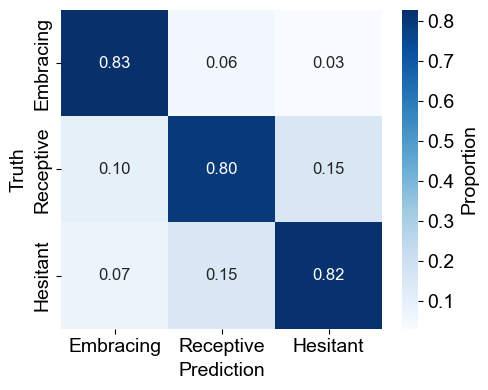

In [ ]:
# 混淆矩阵
print("\nPlotting a confusion matrix...")
cm = confusion_matrix(y, y_pred_cv)

cm1 = cm / sum(cm)
print(cm1)

# 可视化混淆矩阵
plt.figure(figsize=(5, 4))
plt.rc('font', family='Arial', weight='normal')

# 创建热图并获取colorbar对象
heatmap = sns.heatmap(
    cm1, 
    annot=True, 
    fmt='.2f', 
    cmap='Blues',
    annot_kws={'size': 12},  # 设置图块标记字体大小为12
    cbar_kws={'label': 'accuracy'},  # 设置colorbar标签为accuracy
    xticklabels=['Embracing', 'Receptive', 'Hesitant'],
    yticklabels=['Embracing', 'Receptive', 'Hesitant']
)

# 设置colorbar字体为12
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Proportion', fontsize=14)  # 设置colorbar标签字体大小

# 设置坐标轴标签和刻度
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Prediction', fontsize=14)  # 添加x轴标签
plt.ylabel('Truth', fontsize=14)

plt.tight_layout()
# plt.savefig( r'CM_SVC.png', dpi=300,transparent=True,bbox_inches = 'tight')
plt.show()

In [14]:
# 10. 更详细的模型评估
print("\n" + "="*60)
print("详细模型评估")
print("="*60)

# 使用交叉验证预测
from sklearn.model_selection import cross_val_predict
y_pred_cv = cross_val_predict(final_model, X, y, cv=kfold)

# 计算各种评估指标
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(y, y_pred_cv)
precision_macro = precision_score(y, y_pred_cv, average='macro')
recall_macro = recall_score(y, y_pred_cv, average='macro')
f1_macro = f1_score(y, y_pred_cv, average='macro')
precision_weighted = precision_score(y, y_pred_cv, average='weighted')
recall_weighted = recall_score(y, y_pred_cv, average='weighted')
f1_weighted = f1_score(y, y_pred_cv, average='weighted')

print("整体性能指标:")
print(f"  准确率 (Accuracy): {accuracy:.4f}")
print(f"\n宏平均 (Macro-average):")
print(f"  精确率 (Precision): {precision_macro:.4f}")
print(f"  召回率 (Recall): {recall_macro:.4f}")
print(f"  F1分数: {f1_macro:.4f}")
print(f"\n加权平均 (Weighted-average):")
print(f"  精确率 (Precision): {precision_weighted:.4f}")
print(f"  召回率 (Recall): {recall_weighted:.4f}")
print(f"  F1分数: {f1_weighted:.4f}")


详细模型评估
整体性能指标:
  准确率 (Accuracy): 0.8180

宏平均 (Macro-average):
  精确率 (Precision): 0.8217
  召回率 (Recall): 0.8120
  F1分数: 0.8156

加权平均 (Weighted-average):
  精确率 (Precision): 0.8211
  召回率 (Recall): 0.8180
  F1分数: 0.8180


交叉验证混淆矩阵:
[[0.86725664 0.13880126 0.06944444]
 [0.10176991 0.78548896 0.11805556]
 [0.03097345 0.07570978 0.8125    ]]


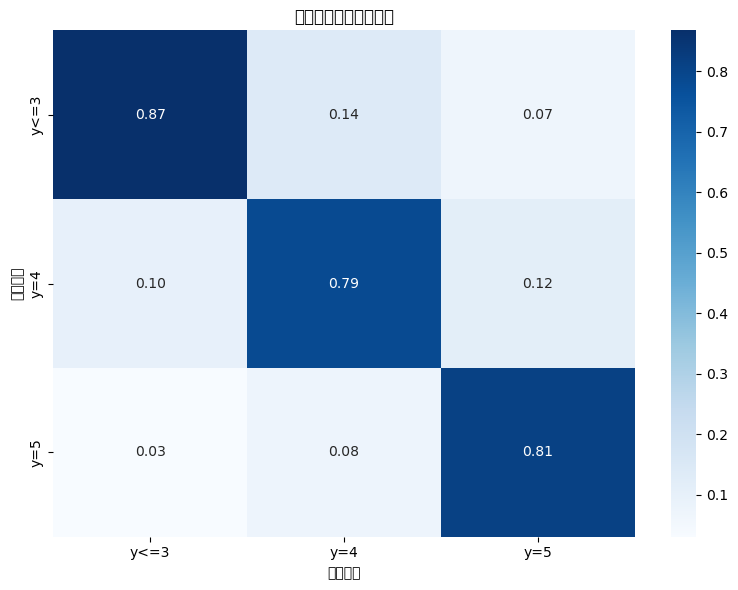

In [15]:
# 混淆矩阵
cm = confusion_matrix(y, y_pred_cv)
print("交叉验证混淆矩阵:")

cm1=cm/sum(cm)
print(cm1)
# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['y<=3', 'y=4', 'y=5'],
            yticklabels=['y<=3', 'y=4', 'y=5'])
plt.xlabel('预测类别')
plt.ylabel('真实类别')
plt.title('五折交叉验证混淆矩阵')
plt.tight_layout()
plt.show()